In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
from diffusers import UNet2DConditionModel, StableDiffusionPipeline, DDIMScheduler
from diffusers.models.attention_processor import AttnProcessor
from transformers import CLIPTextModel, CLIPTokenizer
from skimage.filters import threshold_otsu

In [2]:
def gaussian_kernel(kernel_size=5, sigma=2.0, device=None, dtype=None):
    coords = torch.arange(kernel_size, device=device, dtype=torch.float32) - (kernel_size - 1) / 2.0
    x, y = torch.meshgrid(coords, coords, indexing="xy")
    grid = x**2 + y**2
    kernel = torch.exp(-grid / (2 * (sigma**2)))
    kernel = kernel / kernel.sum()
    return kernel.to(dtype=dtype, device=device)

def gaussian_smoothing(x, kernel_size=5, sigma=2.0):
    B, H, W = x.shape
    device = x.device
    dtype = x.dtype
    kernel = gaussian_kernel(kernel_size, sigma, device=device, dtype=dtype)  # [k,k]
    kernel = kernel.unsqueeze(0).unsqueeze(0)  # [1,1,k,k]
    x_in = x.unsqueeze(1)  # [B,1,H,W]
    pad = kernel_size // 2
    smoothed = F.conv2d(x_in, kernel, padding=pad)
    return smoothed.squeeze(1)  # [B,H,W]


In [3]:
class AttentionStore:
    def __init__(self):
        self.current_maps = {"self": [], "cross": []}
        self.clean_maps = {"self": [], "cross": []}

    def reset(self):
        for k in self.current_maps:
            self.current_maps[k].clear()
        for k in self.clean_maps:
            self.clean_maps[k].clear()

    def add(self, attn, attn_type):
        if attn_type == "self":
            self.current_maps["self"].append(attn)
            self.clean_maps["self"].append(attn.detach().clone().cpu())
        elif attn_type == "cross":
            self.current_maps["cross"].append(attn)
            self.clean_maps["cross"].append(attn.detach().clone().cpu())
        else:
            self.clean_maps.setdefault(attn_type, []).append(attn.detach().cpu())


In [4]:
class AttentionProcessor(AttnProcessor):
    def __init__(self, store, token_indices=None):
        super().__init__()
        self.store = store
        self.token_indices = token_indices

    def __call__(self, attn_module, hidden_states, encoder_hidden_states=None, attention_mask=None, temb=None, scale=1.0):
        residual = hidden_states
        is_cross = encoder_hidden_states is not None

        q = attn_module.to_q(hidden_states)

        if is_cross:
            k = attn_module.to_k(encoder_hidden_states)
            v = attn_module.to_v(encoder_hidden_states)
        else:
            k = attn_module.to_k(hidden_states)
            v = attn_module.to_v(hidden_states)

        q = attn_module.head_to_batch_dim(q)
        k = attn_module.head_to_batch_dim(k)
        v = attn_module.head_to_batch_dim(v)

        attention_probs = attn_module.get_attention_scores(q, k, attention_mask)

        batch_size = hidden_states.shape[0]
        num_heads = attn_module.heads
        sequence_length = hidden_states.shape[1]

        if is_cross:
            cross_attn = attention_probs
            cross_reshaped = cross_attn.reshape(batch_size, num_heads, sequence_length, -1)

            if self.token_indices is not None:
                valid_indices = [idx for idx in self.token_indices if idx < cross_reshaped.shape[-1]]
                if valid_indices:
                    token_attention = cross_reshaped[:, :, :, valid_indices]
                    cross_map = token_attention.mean(dim=1).mean(dim=-1)  # [B, H*W]
                else:
                    cross_map = cross_reshaped.mean(dim=1).mean(dim=-1)
            else:
                cross_map = cross_reshaped.mean(dim=1).mean(dim=-1)

            self.store.add(cross_map, "cross")

        else:
            self_attn = attention_probs
            self_reshaped = self_attn.reshape(batch_size, num_heads, sequence_length, sequence_length)
            self_map = self_reshaped.mean(dim=1)  # [B, H*W, H*W]

            self.store.add(self_map, "self")

        hidden_states = torch.bmm(attention_probs, v)
        hidden_states = attn_module.batch_to_head_dim(hidden_states)
        hidden_states = attn_module.to_out[0](hidden_states)
        hidden_states = attn_module.to_out[1](hidden_states)
        hidden_states = hidden_states + residual

        return hidden_states

In [5]:
def compute_initno_loss(attn_store, latents, token_indices=None, w_cross=1.0, w_self=1.0, w_kl=1.0):
    device = latents.device
    B, C, H, W = latents.shape

    total_loss = torch.tensor(0.0, device=device)

    # Cross-Attention Loss
    cross_loss = torch.tensor(0.0, device=device)
    cross_maps = attn_store.current_maps.get("cross", [])

    if len(cross_maps) > 0:
        for i, cross_map in enumerate(cross_maps):
            if cross_map.device != device:
                cross_map = cross_map.to(device)

            if cross_map.numel() == 0:
                continue

            if cross_map.ndim == 2:
                spatial_attn = cross_map
            else:
                spatial_attn = cross_map.view(B, -1)

            spatial_min = spatial_attn.min(dim=1, keepdim=True)[0]
            spatial_max = spatial_attn.max(dim=1, keepdim=True)[0]
            spatial_norm = (spatial_attn - spatial_min) / (spatial_max - spatial_min + 1e-8)

            k = max(10, spatial_norm.shape[1] // 64)
            topk_vals, _ = torch.topk(spatial_norm, k=k, dim=1)

            if topk_vals.numel() > 0:
                current_loss = torch.relu(0.8 - topk_vals.mean())
                cross_loss = cross_loss + current_loss

    if cross_loss.item() > 0:
        cross_loss = cross_loss / max(1, len(cross_maps))
        total_loss = total_loss + w_cross * cross_loss

    # Self-Attention Loss
    self_loss = torch.tensor(0.0, device=device)
    self_maps = attn_store.current_maps.get("self", [])

    if len(self_maps) >= 2:
        map1 = self_maps[0]
        map2 = self_maps[1]

        if map1.device != device:
            map1 = map1.to(device)
            map2 = map2.to(device)

        if map1.shape == map2.shape:
            flat1 = map1.view(B, -1)
            flat2 = map2.view(B, -1)

            flat1_norm = F.normalize(flat1, p=2, dim=-1)
            flat2_norm = F.normalize(flat2, p=2, dim=-1)
            similarity = (flat1_norm * flat2_norm).sum(dim=-1).mean()

            self_loss = similarity
            total_loss = total_loss + w_self * self_loss

    # 3) KL Divergence on Latents
    eps = 1e-6
    latents_flat = latents.view(B, -1)
    latent_mean = latents_flat.mean(dim=1)
    latent_var = latents_flat.var(dim=1, unbiased=False) + eps

    kl_per_sample = 0.5 * (latent_var + latent_mean.pow(2) - 1 - torch.log(latent_var))
    kl_loss = kl_per_sample.mean()
    total_loss = total_loss + w_kl * kl_loss

    print(f"[TOTAL LOSS] cross: {cross_loss.item():.4f}, self: {self_loss.item():.4f}, kl: {kl_loss.item():.6f}")

    return total_loss


In [6]:
def initno_optimization(latents, unet, text_embeds, tokenizer, scheduler, token_indices, num_steps=100, lr=1e-2):
    latents = latents.detach().requires_grad_(True)
    optimizer = optim.Adam([latents], lr=lr)

    unet.eval()
    for p in unet.parameters():
        p.requires_grad = False

    attn_store = AttentionStore()
    unet.set_attn_processor(AttentionProcessor(attn_store, token_indices))

    latents_before = latents.detach().clone()

    for step_idx in range(num_steps):
        optimizer.zero_grad()

        t_idx = np.random.randint(0, len(scheduler.timesteps))
        t = torch.tensor([scheduler.timesteps[t_idx]], device=latents.device, dtype=torch.long)

        noise_pred = unet(latents, t, encoder_hidden_states=text_embeds).sample

        loss = compute_initno_loss(
            attn_store,
            latents,
            token_indices,
            w_cross=2.0,
            w_self=2.0,
            w_kl=300.0
        )

        loss.backward(retain_graph=True)

        optimizer.step()

        attn_store.reset()

        if step_idx % 10 == 0:
            grad_norm = latents.grad.norm().item() if latents.grad is not None else 0.0
            print(f"Step {step_idx}: Loss = {loss.item():.6f}")
            print_latent_stats(latents, f"Step {step_idx}")

    return latents.detach()

In [7]:
def print_latent_stats(latents, name="Latents"):
    print(f"--- {name} ---")
    print(f"Shape: {latents.shape}")
    print(f"Min: {latents.min().item():.6f}, Max: {latents.max().item():.6f}")
    print(f"Mean: {latents.mean().item():.6f}, Std: {latents.std().item():.6f}")
    print(f"Sum: {latents.sum().item():.6f}")

In [8]:
def generate_image(prompt, token_indices, seed=0, device="cuda"):
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
    text_model = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
    text_input = tokenizer(prompt, return_tensors="pt", padding=True)
    text_embeds = text_model(**text_input).last_hidden_state.to(device)

    # Load UNet model & scheduler
    unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to(device)
    scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
    scheduler.set_timesteps(50)

    original_processors = unet.attn_processors

    torch.manual_seed(seed)
    latents = torch.randn((1, unet.config.in_channels, 64, 64), device=device)
    print_latent_stats(latents, "initial")

    optimized_latents = initno_optimization(
        latents.clone(),
        unet,
        text_embeds,
        tokenizer,
        scheduler,
        token_indices,
        num_steps=200,
        lr=5e-3
    )
    print_latent_stats(optimized_latents, "optimized")

    unet.set_attn_processor(original_processors)

    pipe = StableDiffusionPipeline.from_pretrained(
        "CompVis/stable-diffusion-v1-4",
        unet=unet,
        scheduler=scheduler,
        tokenizer=tokenizer,
        text_encoder=text_model,
        safety_checker=None
    )
    pipe = pipe.to(device)

    img_original = pipe(
        prompt,
        num_inference_steps=50,
        guidance_scale=7.5,
        latents=latents
    ).images[0]

    img_optimized = pipe(
        prompt,
        num_inference_steps=50,
        guidance_scale=7.5,
        latents=optimized_latents
    ).images[0]

    return img_original, img_optimized

In [9]:
def show_side_by_side(img1, img2):
    fig, axs = plt.subplots(1, 2, figsize=(8,4))

    for ax, img in zip(axs, [img1, img2]):
        ax.imshow(img)
        ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.savefig("output.png", bbox_inches='tight')
    plt.show()

In [10]:
prompt = "a giraffe and a tree"
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_input = tokenizer(prompt, return_tensors="pt", padding=True)
print("Tokens:", tokenizer.convert_ids_to_tokens(text_input.input_ids[0]))
print("Token indices:", [i for i, token in enumerate(tokenizer.convert_ids_to_tokens(text_input.input_ids[0]))])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Tokens: ['<|startoftext|>', 'a</w>', 'giraffe</w>', 'and</w>', 'a</w>', 'tree</w>', '<|endoftext|>']
Token indices: [0, 1, 2, 3, 4, 5, 6]


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

--- initial ---
Shape: torch.Size([1, 4, 64, 64])
Min: -3.893608, Max: 3.832417
Mean: 0.002974, Std: 1.008122
Sum: 48.728142
[TOTAL LOSS] cross: 0.0766, self: 0.4292, kl: 0.000070
Step 0: Loss = 1.032473
--- Step 0 ---
Shape: torch.Size([1, 4, 64, 64])
Min: -3.888608, Max: 3.827417
Mean: 0.002943, Std: 1.007125
Sum: 48.216274
[TOTAL LOSS] cross: 0.1298, self: 0.4460, kl: 0.000055
[TOTAL LOSS] cross: 0.0752, self: 0.4230, kl: 0.000040
[TOTAL LOSS] cross: 0.1002, self: 0.4867, kl: 0.000027
[TOTAL LOSS] cross: 0.0686, self: 0.4212, kl: 0.000017
[TOTAL LOSS] cross: 0.0906, self: 0.4636, kl: 0.000011
[TOTAL LOSS] cross: 0.0447, self: 0.4188, kl: 0.000006
[TOTAL LOSS] cross: 0.0699, self: 0.5457, kl: 0.000003
[TOTAL LOSS] cross: 0.0740, self: 0.4419, kl: 0.000001
[TOTAL LOSS] cross: 0.0542, self: 0.5438, kl: 0.000001
[TOTAL LOSS] cross: 0.0596, self: 0.4141, kl: 0.000001
Step 10: Loss = 0.947721
--- Step 10 ---
Shape: torch.Size([1, 4, 64, 64])
Min: -3.874847, Max: 3.788205
Mean: 0.001074, S

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

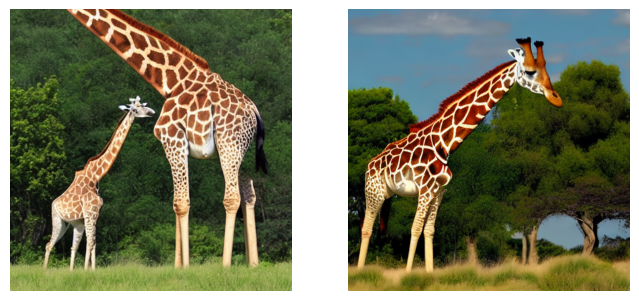

In [11]:
# Indices should be set manually, based on the prompt
token_indices = [2, 5]

img_original, img_optimized = generate_image(prompt, token_indices, seed=500)
show_side_by_side(img_original, img_optimized)
img_original.save("output-orig.png")
img_optimized.save("output-opt.png")